In [ ]:
%pip list

In [2]:
import sys
print('Python version: {}'.format(sys.version))

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [1]:
import pandas as pd
from tqdm import tqdm
import json
import os
import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix


import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import warnings
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\Users\oleba\Documents\git\graph-convolutional-neural-network\.venv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\oleba\Documents\git\graph-convolutional-neural-network\.venv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\oleba\Documen

In [2]:
edges_path = 'datasets-master/git_web_ml/git_edges.csv'
targets_path = 'datasets-master/git_web_ml/git_target.csv'
features_path = 'datasets-master/git_web_ml/git_features.json'

In [3]:
# Read in edges
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility
display(edges.shape, edges.head())

(289003, 2)

,source,target
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [4]:
# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)
    
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 37700/37700 [00:00<00:00, 57768.12it/s]


In [5]:
node_features = pd.DataFrame(features_matrix, index = features.keys())
display(node_features.shape, node_features.head())

(37700, 4005)

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Read in targets
targets = pd.read_csv(targets_path)
targets.index = targets.id.astype(str)
targets = targets.loc[features.keys(), :]
display(targets.shape, targets.head(), targets.ml_target.value_counts(normalize=True))

(37700, 3)

,id,name,ml_target
id,,,
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


0    0.741671
1    0.258329
Name: ml_target, dtype: float64

In [7]:
G = sg.StellarGraph(node_features, edges.astype(str))

In [8]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 37700, Edges: 289003

 Node types:
  default: [37700]
    Features: float32 vector, length 4005
    Edge types: default-default->default

 Edge types:
    default-default->default: [289003]
        Weights: all 1 (default)
        Features: none


In [9]:
train_pages, test_pages = train_test_split(targets, train_size=200)
val_pages, test_pages = train_test_split(test_pages, train_size=200)

In [10]:
train_pages.shape, val_pages.shape, test_pages.shape

((200, 3), (200, 3), (37300, 3))

In [13]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_pages['ml_target'])
val_targets = target_encoding.transform(val_pages['ml_target'])
test_targets = target_encoding.transform(test_pages['ml_target'])

In [12]:
# Get the adjacency matrix
A = G.to_adjacency_matrix(weighted=False)

# Add self-connections
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())

# Degree matrix to the power of -1/2
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)

# Normalise the Adjacency matrix
A_norm = A.dot(D_t).transpose().dot(D_t).todense()

In [13]:
# Define the function to get these indices
def get_node_indices(G, ids):
    # find the indices of the nodes
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # in-built function makes it really easy
    # back to the original shape
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # add 1 extra dimension
    
    return node_indices

train_indices = get_node_indices(G, train_pages.index)
val_indices = get_node_indices(G, val_pages.index)
test_indices = get_node_indices(G, test_pages.index)

In [14]:
# Expand dimensions
features_input = np.expand_dims(features_matrix, 0)
A_input = np.expand_dims(A_norm, 0)

y_train = np.expand_dims(train_targets, 0)
y_val = np.expand_dims(val_targets, 0)
y_test = np.expand_dims(test_targets, 0)

In [15]:
from stellargraph.layer.gcn import GraphConvolution, GatherIndices

In [16]:
# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

In [17]:
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]
x_inp

[<KerasTensor: shape=(1, 37700, 4005) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
 <KerasTensor: shape=(1, 37700, 37700) dtype=float32 (created by layer 'input_3')>]

In [19]:
x = Dropout(0.5)(x_features)
x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

In [20]:
model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 37700, 4005)]   0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (1, 37700, 4005)     0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, 37700, 37700)]  0                                            
__________________________________________________________________________________________________
graph_convolution_2 (GraphConvo (1, 37700, 32)       128192      dropout_2[0][0]                  
                                                                 input_3[0][0]                

In [21]:
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [45]:
es_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [24]:
history = model.fit(
    x = [features_input, train_indices, A_input],
    y = y_train,
    batch_size = 32,
    epochs=200,
    validation_data=([features_input, val_indices, A_input], y_val),
    verbose=1,
    shuffle=False,
    callbacks=[es_callback],
)

Epoch 1/200
1/1 [==============================] - 198s 198s/step - loss: 0.6941 - acc: 0.4400 - val_loss: 0.6409 - val_acc: 0.7750
Epoch 2/200
1/1 [==============================] - 95s 95s/step - loss: 0.6443 - acc: 0.7200 - val_loss: 0.5901 - val_acc: 0.7750
Epoch 3/200
1/1 [==============================] - 98s 98s/step - loss: 0.6011 - acc: 0.7200 - val_loss: 0.5447 - val_acc: 0.7750
Epoch 4/200
1/1 [==============================] - 98s 98s/step - loss: 0.5575 - acc: 0.7200 - val_loss: 0.5129 - val_acc: 0.7750
Epoch 5/200
1/1 [==============================] - 109s 109s/step - loss: 0.5320 - acc: 0.7200 - val_loss: 0.5031 - val_acc: 0.7750
Epoch 6/200
1/1 [==============================] - 105s 105s/step - loss: 0.5229 - acc: 0.7200 - val_loss: 0.5026 - val_acc: 0.7750
Epoch 7/200
1/1 [==============================] - 100s 100s/step - loss: 0.5115 - acc: 0.7200 - val_loss: 0.4909 - val_acc: 0.7750
Epoch 8/200
1/1 [==============================] - 107s 107s/step - loss: 0.4825 -

In [25]:
test_preds = model.predict([features_input, test_indices, A_input])

In [27]:
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print(confusion_matrix(true, bin_pred, normalize='true'))
    
    return auc, pr, f_score
    



In [42]:
auc, pr, f_score = evaluate_preds(test_targets.ravel(),test_preds[0].ravel())

ROC AUC: 0.8855380533388334
PR AUC: 0.7430231163326726
F1 score: 0.6831320233159065
[[0.95231726 0.04768274]
 [0.41025109 0.58974891]]


In [54]:
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)
all_indices = get_node_indices(G, targets.index)
emb = embedding_model.predict([features_input, all_indices, A_input])
emb.shape

(1, 37700, 32)

In [55]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

c:\Users\oleba\Documents\git\graph-convolutional-neural-network\.venv\lib\site-packages\numba\core\errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


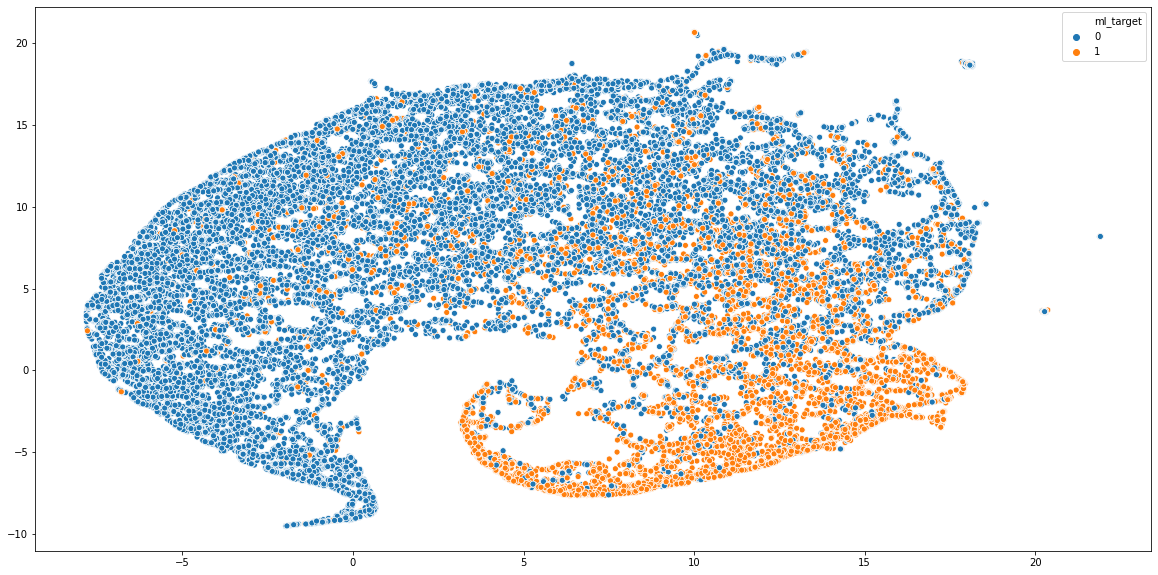

In [57]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['ml_target'])

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf = RandomForestClassifier()

rf.fit(node_features.loc[train_pages.index, :], train_targets.ravel())

test_preds = rf.predict_proba(node_features.loc[test_pages.index, :])[:, 1]
evaluate_preds(test_targets.ravel(), test_preds)

ROC AUC: 0.8409632000657918
PR AUC: 0.7091492821465811
F1 score: 0.5649756298482873
[[0.96987212 0.03012788]
 [0.57215637 0.42784363]]


(0.8409632000657918, 0.7091492821465811, 0.5649756298482873)

In [33]:
# 1000 training examples
train_pages, test_pages = train_test_split(targets, train_size=1000)
val_pages, test_pages = train_test_split(test_pages, train_size=500)

train_targets = target_encoding.fit_transform(train_pages['ml_target'])
val_targets = target_encoding.transform(val_pages['ml_target'])
test_targets = target_encoding.transform(test_pages['ml_target'])


In [36]:
# Initialise the generator
generator = FullBatchNodeGenerator(G, method="gcn")

# Use the .flow method to prepare it for use with GCN
train_gen = generator.flow(train_pages.index, train_targets)
val_gen = generator.flow(val_pages.index, val_targets)
test_gen = generator.flow(test_pages.index, test_targets)

Using GCN (local pooling) filters...


In [41]:
# Build necessary layers
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

# Access the input and output tensors
x_inp, x_out = gcn.in_out_tensors()

# Pass the output tensor through the dense layer with sigmoid
predictions = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

In [43]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)